In [1]:
import numpy as np
import pyreadr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import textwrap

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from utils import pca, preprocess_data, plot_bar_importance, plot_confusion_matrix

In [2]:
path = "./gss_16.rda"

In [3]:
data = pyreadr.read_r(path)

In [4]:
df = data["gss16"]

In [5]:
columns_to_check = ['educ', 'wrkstat']
df.dropna(subset=columns_to_check, inplace=True)

In [6]:
df['emailtotal'] = np.where(df['emailhr'].isna() | df['emailmin'].isna(), np.nan, df['emailhr'] * 60 + df['emailmin'])
df = df.drop(['emailhr', 'emailmin'], axis=1)

In [7]:
df.shape

(2858, 8)

In [8]:
df.dropna(subset=['emailtotal'], inplace=True)

In [9]:
df.shape

(1648, 8)

In [10]:
value_to_index = {}

for col in df.columns.tolist():
    try:
        unique_set = np.unique(df[col].to_numpy()).tolist()
        unique_set = [x for x in unique_set if not math.isnan(x)]
        print(col, unique_set)
        unique_set.sort()
        value_to_index[col] = dict(zip(unique_set, unique_set))
    except:
        #print(col, list(set(df[col].tolist())))
        unique_set = list(set(df[col].tolist()))
        chosens = []
        for i in unique_set:
            if isinstance(i, float):
                if math.isnan(i):
                    continue
            #print(type(i), i)
            chosens.append(i)
        unique_set = chosens
        
        print(col, unique_set)
        unique_set.sort()
    
        if col == "advfront":
            value_to_index[col] = {'Strongly disagree': 1, 'Disagree': 2, 'Dont know': 3, 'Agree': 4, 'Strongly agree': 5}
        elif col == "polviews":
            value_to_index[col] = {'Extrmly conservative': 1, 'Conservative': 2, 'Slghtly conservative': 3, 'Moderate': 4, 'Slightly liberal': 5, 'Liberal': 6, 'Extremely liberal': 7}
        elif col == "educ" or col == "wrkstat":
            value_to_index[col] = dict(zip(unique_set, range(len(unique_set))))
        else:
            value_to_index[col] = dict(zip(unique_set, range(1, len(unique_set) + 1)))
        
print(value_to_index)

harass5 ['Yes', 'Does not apply (i do not have a job/superior/co-worker)', 'No']
educ [2.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
polviews ['Extrmly conservative', 'Slghtly conservative', 'Slightly liberal', 'Moderate', 'Liberal', 'Extremely liberal', 'Conservative']
advfront ['Strongly disagree', 'Agree', 'Strongly agree', 'Disagree', 'Dont know']
snapchat ['Yes', 'No']
instagrm ['Yes', 'No']
wrkstat ['Keeping house', 'Retired', 'School', 'Other', 'Working parttime', 'Unempl, laid off', 'Temp not working', 'Working fulltime']
emailtotal [0.0, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 40.0, 45.0, 48.0, 50.0, 59.0, 60.0, 70.0, 90.0, 100.0, 105.0, 120.0, 150.0, 180.0, 210.0, 240.0, 300.0, 360.0, 420.0, 480.0, 510.0, 540.0, 570.0, 600.0, 720.0, 750.0, 840.0, 900.0, 960.0, 1020.0, 1080.0, 1200.0, 1215.0, 1260.0, 1320.0, 1440.0, 1500.0, 1680.0, 1800.0, 1920.0, 2100.0, 2160.0, 2400.0, 2520.0, 2640.0, 2700.0, 2820.0, 2880.0, 3000.0,

In [11]:
for col in df.columns.tolist():
    if col == 'emailtotal' or col == "wrkstat":
        continue
    df[col] = df[col].map(value_to_index[col])

In [12]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat,emailtotal
0,NaN,16.0,4.0,5.0,NaN,NaN,Working fulltime,720.0
1,NaN,12.0,6.0,2.0,1.0,1.0,Working fulltime,30.0
3,NaN,12.0,4.0,2.0,NaN,NaN,Working parttime,10.0
5,NaN,14.0,5.0,5.0,1.0,2.0,Keeping house,120.0
6,NaN,14.0,5.0,5.0,NaN,NaN,Working fulltime,2400.0
...,...,...,...,...,...,...,...,...
2860,NaN,13.0,4.0,4.0,NaN,NaN,Retired,60.0
2862,NaN,20.0,7.0,4.0,1.0,2.0,Working fulltime,1200.0
2863,NaN,15.0,2.0,2.0,NaN,NaN,Working fulltime,120.0
2864,2.0,14.0,4.0,NaN,NaN,NaN,Keeping house,0.0


In [13]:
categorical_columns = ['harass5', 'polviews', 'advfront', 'snapchat', 'instagrm', 'wrkstat']

df[categorical_columns] = df[categorical_columns].fillna(0)

df['educ'] = df['educ'].fillna(21)

In [14]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat,emailtotal
0,0.0,16.0,4.0,5.0,0.0,0.0,Working fulltime,720.0
1,0.0,12.0,6.0,2.0,1.0,1.0,Working fulltime,30.0
3,0.0,12.0,4.0,2.0,0.0,0.0,Working parttime,10.0
5,0.0,14.0,5.0,5.0,1.0,2.0,Keeping house,120.0
6,0.0,14.0,5.0,5.0,0.0,0.0,Working fulltime,2400.0
...,...,...,...,...,...,...,...,...
2860,0.0,13.0,4.0,4.0,0.0,0.0,Retired,60.0
2862,0.0,20.0,7.0,4.0,1.0,2.0,Working fulltime,1200.0
2863,0.0,15.0,2.0,2.0,0.0,0.0,Working fulltime,120.0
2864,2.0,14.0,4.0,0.0,0.0,0.0,Keeping house,0.0


In [15]:
#df["wrkstat"] = df["wrkstat"].astype(np.int16)
casted_columns = ['harass5', 'educ', 'polviews', 'advfront', 'snapchat', 'instagrm', 'emailtotal']
#casted_columns = ['emailtotal']

for col in casted_columns:
    df[col] = df[col].astype(np.int16)

In [16]:
df

,harass5,educ,polviews,advfront,snapchat,instagrm,wrkstat,emailtotal
0,0,16,4,5,0,0,Working fulltime,720
1,0,12,6,2,1,1,Working fulltime,30
3,0,12,4,2,0,0,Working parttime,10
5,0,14,5,5,1,2,Keeping house,120
6,0,14,5,5,0,0,Working fulltime,2400
...,...,...,...,...,...,...,...,...
2860,0,13,4,4,0,0,Retired,60
2862,0,20,7,4,1,2,Working fulltime,1200
2863,0,15,2,2,0,0,Working fulltime,120
2864,2,14,4,0,0,0,Keeping house,0


In [17]:
categorical_columns = ['harass5', 'snapchat', 'instagrm', 'polviews', 'advfront', 'educ']
numerical_columns = ['emailtotal']

df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=False)
#scaler = MinMaxScaler()
scaler = StandardScaler()

df_encoded[numerical_columns] = scaler.fit_transform(df_encoded[numerical_columns])
#df_encoded = scaler.fit_transform(df_encoded)

df_encoded

,wrkstat,emailtotal,harass5_0,harass5_1,harass5_2,harass5_3,snapchat_0,snapchat_1,snapchat_2,instagrm_0,...,educ_11,educ_12,educ_13,educ_14,educ_15,educ_16,educ_17,educ_18,educ_19,educ_20
0,Working fulltime,0.445574,1,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,Working fulltime,-0.568931,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
3,Working parttime,-0.598337,1,0,0,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0
5,Keeping house,-0.436604,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
6,Working fulltime,2.915674,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2860,Retired,-0.524822,1,0,0,0,1,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2862,Working fulltime,1.151317,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2863,Working fulltime,-0.436604,1,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2864,Keeping house,-0.613040,0,0,1,0,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [18]:
y = df_encoded["wrkstat"]
y = y.to_numpy()

x = df_encoded.drop("wrkstat", axis=1).to_numpy()
U, reduced_x = pca(x=x, alpha=0.5)

x.shape, y, reduced_x

((1648, 43),
 array(['Working fulltime', 'Working fulltime', 'Working parttime', ...,
        'Working fulltime', 'Keeping house', 'Working fulltime'],
       dtype=object),
 array([[ 0.76516265, -1.16874744, -0.15042556,  0.18296905],
        [ 0.0738515 ,  0.73155778,  1.01875332,  0.28174455],
        [ 1.41275401, -0.15268227, -0.10413859, -0.70098884],
        ...,
        [ 1.26932849, -0.34444335, -0.12803762,  0.26231042],
        [ 0.61683124,  0.36932971, -1.26404303, -0.81219695],
        [ 1.47759915, -0.40272091,  0.23605025, -0.18099993]]))

In [19]:
original_df = data["gss16"]

func_x, func_y = preprocess_data(df=original_df, remove_email_null=True, use_text_categorical=False, one_hot_encode=True)

U, reduced_func_x = pca(x=func_x, alpha=0.5)

reduced_func_x.shape

(1648, 4)

In [20]:
np.sum((reduced_x - reduced_func_x)**2)

0.0

In [21]:
X_train, X_test, y_train, y_test = train_test_split(reduced_x, y, test_size=0.4, random_state=42)

In [22]:
model = LogisticRegression(multi_class='multinomial', solver='saga')
model.fit(X_train, y_train)

LogisticRegression(multi_class='multinomial', solver='saga')

In [23]:
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

                  precision    recall  f1-score   support

   Keeping house       0.00      0.00      0.00        58
           Other       0.00      0.00      0.00         8
         Retired       0.00      0.00      0.00       109
          School       0.00      0.00      0.00        14
Temp not working       0.00      0.00      0.00        15
Unempl, laid off       0.00      0.00      0.00        25
Working fulltime       0.53      1.00      0.69       351
Working parttime       0.00      0.00      0.00        80

        accuracy                           0.53       660
       macro avg       0.07      0.12      0.09       660
    weighted avg       0.28      0.53      0.37       660



c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Thanh_Tuyet\.conda\envs\pytorch_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

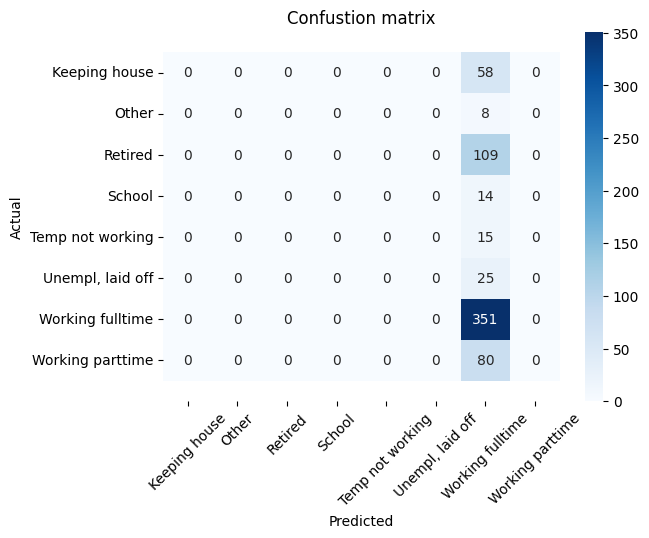

In [24]:
classes = model.classes_
plot_confusion_matrix(y_test, y_pred, classes=classes)

In [25]:
features_list = df_encoded.columns.tolist()
features_list.remove('wrkstat')
len(features_list), features_list

(43,
 ['emailtotal',
  'harass5_0',
  'harass5_1',
  'harass5_2',
  'harass5_3',
  'snapchat_0',
  'snapchat_1',
  'snapchat_2',
  'instagrm_0',
  'instagrm_1',
  'instagrm_2',
  'polviews_0',
  'polviews_1',
  'polviews_2',
  'polviews_3',
  'polviews_4',
  'polviews_5',
  'polviews_6',
  'polviews_7',
  'advfront_0',
  'advfront_1',
  'advfront_2',
  'advfront_3',
  'advfront_4',
  'advfront_5',
  'educ_2',
  'educ_4',
  'educ_5',
  'educ_6',
  'educ_7',
  'educ_8',
  'educ_9',
  'educ_10',
  'educ_11',
  'educ_12',
  'educ_13',
  'educ_14',
  'educ_15',
  'educ_16',
  'educ_17',
  'educ_18',
  'educ_19',
  'educ_20'])

In [26]:
index_to_features_list = dict(zip(range(len(features_list)), features_list))

index_to_features_list

{0: 'emailtotal',
 1: 'harass5_0',
 2: 'harass5_1',
 3: 'harass5_2',
 4: 'harass5_3',
 5: 'snapchat_0',
 6: 'snapchat_1',
 7: 'snapchat_2',
 8: 'instagrm_0',
 9: 'instagrm_1',
 10: 'instagrm_2',
 11: 'polviews_0',
 12: 'polviews_1',
 13: 'polviews_2',
 14: 'polviews_3',
 15: 'polviews_4',
 16: 'polviews_5',
 17: 'polviews_6',
 18: 'polviews_7',
 19: 'advfront_0',
 20: 'advfront_1',
 21: 'advfront_2',
 22: 'advfront_3',
 23: 'advfront_4',
 24: 'advfront_5',
 25: 'educ_2',
 26: 'educ_4',
 27: 'educ_5',
 28: 'educ_6',
 29: 'educ_7',
 30: 'educ_8',
 31: 'educ_9',
 32: 'educ_10',
 33: 'educ_11',
 34: 'educ_12',
 35: 'educ_13',
 36: 'educ_14',
 37: 'educ_15',
 38: 'educ_16',
 39: 'educ_17',
 40: 'educ_18',
 41: 'educ_19',
 42: 'educ_20'}

In [27]:
index_to_features_list_update = {}
for k, v in index_to_features_list.items():
    if v == "emailtotal":
        index_to_features_list_update[k] = v
    else:
        field, index = v.split("_")
        val_to_ind = {v: k for k, v in value_to_index[field].items()}
        #print(val_to_ind)
        if int(index) in val_to_ind:
            text_value = val_to_ind[int(index)]
            if isinstance(text_value, str):
                space_split = text_value.split(" ")
                if len(space_split) == 1:
                    index_to_features_list_update[k] = "{}_{}".format(field, space_split[0])
                else:
                    index_to_features_list_update[k] = "{}_{}".format(field, "_".join(space_split))
            else:
                index_to_features_list_update[k] = "{}_{}".format(field, int(text_value))
        else:
            index_to_features_list_update[k] = "{}_{}".format(field, "Unknown")
index_to_features_list = index_to_features_list_update
index_to_features_list

{0: 'emailtotal',
 1: 'harass5_Unknown',
 2: 'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
 3: 'harass5_No',
 4: 'harass5_Yes',
 5: 'snapchat_Unknown',
 6: 'snapchat_No',
 7: 'snapchat_Yes',
 8: 'instagrm_Unknown',
 9: 'instagrm_No',
 10: 'instagrm_Yes',
 11: 'polviews_Unknown',
 12: 'polviews_Extrmly_conservative',
 13: 'polviews_Conservative',
 14: 'polviews_Slghtly_conservative',
 15: 'polviews_Moderate',
 16: 'polviews_Slightly_liberal',
 17: 'polviews_Liberal',
 18: 'polviews_Extremely_liberal',
 19: 'advfront_Unknown',
 20: 'advfront_Strongly_disagree',
 21: 'advfront_Disagree',
 22: 'advfront_Dont_know',
 23: 'advfront_Agree',
 24: 'advfront_Strongly_agree',
 25: 'educ_2',
 26: 'educ_4',
 27: 'educ_5',
 28: 'educ_6',
 29: 'educ_7',
 30: 'educ_8',
 31: 'educ_9',
 32: 'educ_10',
 33: 'educ_11',
 34: 'educ_12',
 35: 'educ_13',
 36: 'educ_14',
 37: 'educ_15',
 38: 'educ_16',
 39: 'educ_17',
 40: 'educ_18',
 41: 'educ_19',
 42: 'educ_20'}

In [28]:
pseudo_label = np.unique(y)
index_to_pseudo_label = dict(zip(range(len(pseudo_label)), pseudo_label))
index_to_pseudo_label

{0: 'Keeping house',
 1: 'Other',
 2: 'Retired',
 3: 'School',
 4: 'Temp not working',
 5: 'Unempl, laid off',
 6: 'Working fulltime',
 7: 'Working parttime'}

In [29]:
original_weights = model.coef_.dot(U.T)

In [30]:
importance = {}
for i in range(original_weights.shape[0]):
    importance[index_to_pseudo_label[i]] = dict(zip(np.vectorize(lambda x: index_to_features_list[x])(np.argsort(np.abs(original_weights[i]))[::-1]), np.round(original_weights[i][np.argsort(np.abs(original_weights[i]))[::-1]], 3)))
    
importance

{'Keeping house': {'emailtotal': -0.167,
  'advfront_Agree': 0.135,
  'snapchat_No': 0.105,
  'instagrm_Unknown': -0.102,
  'snapchat_Unknown': -0.102,
  'instagrm_No': 0.09,
  'harass5_Unknown': 0.082,
  'advfront_Unknown': -0.081,
  'harass5_No': -0.07,
  'polviews_Moderate': 0.06,
  'advfront_Strongly_agree': -0.052,
  'educ_12': 0.034,
  'educ_16': -0.027,
  'polviews_Liberal': -0.016,
  'polviews_Slghtly_conservative': -0.016,
  'polviews_Slightly_liberal': -0.013,
  'instagrm_Yes': 0.012,
  'polviews_Extremely_liberal': -0.011,
  'harass5_Yes': -0.008,
  'educ_13': -0.006,
  'educ_20': -0.004,
  'educ_18': -0.004,
  'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)': -0.004,
  'educ_15': 0.003,
  'educ_10': 0.003,
  'polviews_Conservative': -0.003,
  'snapchat_Yes': -0.003,
  'educ_11': 0.002,
  'advfront_Disagree': -0.002,
  'educ_8': 0.002,
  'educ_19': -0.001,
  'educ_17': -0.001,
  'educ_14': -0.001,
  'advfront_Dont_know': 0.001,
  'advfront_Strongly_disagree'